In [3]:
import sys
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [183]:
def rectify(h):
    h = h.reshape((4,2))
    hnew = np.zeros((4,2),dtype = np.float32)

    add = h.sum(1)
    hnew[0] = h[np.argmin(add)]
    hnew[2] = h[np.argmax(add)]

    diff = np.diff(h,axis = 1)
    hnew[1] = h[np.argmin(diff)]
    hnew[3] = h[np.argmax(diff)]

    return hnew

In [185]:
def getCards(im, numcards=2):
    if numcards==2:
        a = 150
    else:
        a = 120
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    flag, thresh = cv2.threshold(gray, a, 255, cv2.THRESH_BINARY)
    image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea,reverse=True)[:numcards]
    
    for card in contours:
        peri = cv2.arcLength(card,True)
        approx = rectify(cv2.approxPolyDP(card,0.0975*peri,True))

        h = np.array([ [0,0],[449,0],[449,449],[0,449] ],np.float32)

        transform = cv2.getPerspectiveTransform(approx,h) # how do these arguments work?
        warp = cv2.warpPerspective(im,transform,(450,450)) # how do these arguments work?
        warp = warp[:,0:110]
#         fig, ax = plt.subplots(figsize=(2, 1))
#         plt.imshow(warp,'gray')
#         plt.title("")
#         plt.xticks([]),plt.yticks([])
#         plt.show()

        yield warp

In [186]:
def preprocess(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # blur = cv2.GaussianBlur(gray,(5,5),2 )
    # thresh = cv2.adaptiveThreshold(blur,255,1,1,11,1) # do we need this?
    retval, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)
    return thresh

In [194]:
# We will want to pickle the dictionary

def get_training(training_labels_filename, training_image_filename, num_training_cards):
    training = {}
    labels = {}
    
    for line in file(training_labels_filename):
        key, num, suit = line.strip().split()
        labels[int(key)] = (num, suit)

    print "Training"
    
    for f in training_image_filename:
        im = cv2.imread(f)
        for i, c in enumerate(getCards(im, num_training_cards/len(training_image_filename))):
            ind = i+(13*training_image_filename.index(f))
            training[ind] = (labels[ind], preprocess(c))

#             fig, ax = plt.subplots(figsize=(2, 1))
#             plt.imshow(c,'gray')
#             plt.title("")
#             plt.xticks([]),plt.yticks([])
#             plt.show()
    print "Done training"
    return training

In [277]:
def find_closest_card(training, im):
    features = preprocess(im)
    return sorted(training.values(), key=lambda x: orb_match(x[1], features), reverse=True)[0][0]

In [200]:
def imgdiff(img1, img2):
#     img1 = cv2.GaussianBlur(img1, (5, 5), 0)
#     img2 = cv2.GaussianBlur(img2, (5, 5), 0)
    diff = cv2.absdiff(img1, img2)
#     diff = cv2.GaussianBlur(diff, (5, 5), 5)
#     flag, diff = cv2.threshold(diff, 200, 255, cv2.THRESH_BINARY)
#     fig, ax = plt.subplots(1, 3, figsize=(3, 2), sharey=True)
#     plt.subplot(131), plt.imshow(img1), plt.title('')
#     plt.xticks([]), plt.yticks([])
#     plt.subplot(132), plt.imshow(img2), plt.title('')
#     plt.xticks([]), plt.yticks([])
#     plt.subplot(133), plt.imshow(diff), plt.title('')
#     plt.xticks([]), plt.yticks([])
#     plt.show()
    return np.sum(diff)

Training
Done training


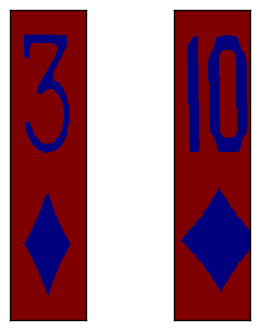

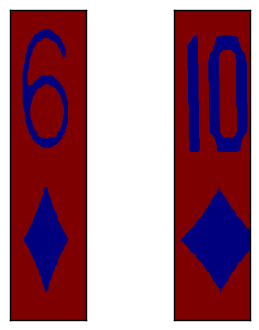

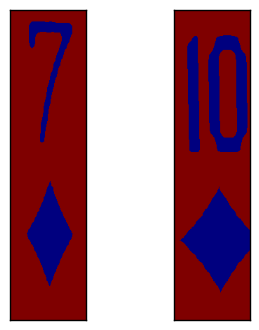

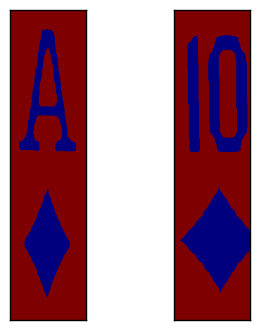

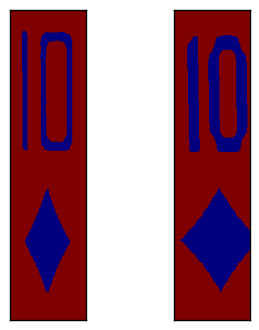

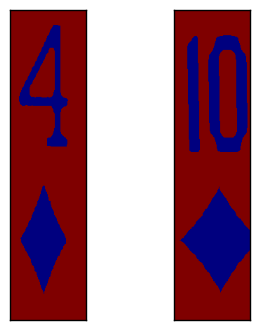

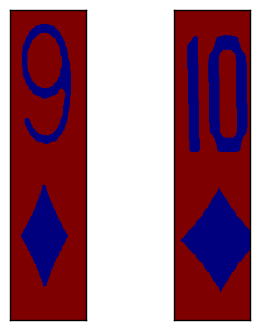

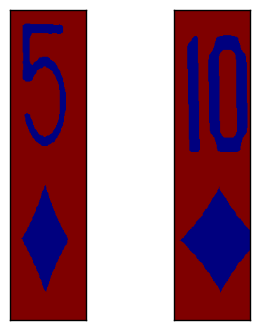

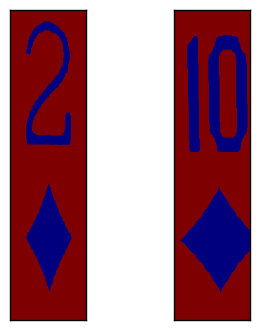

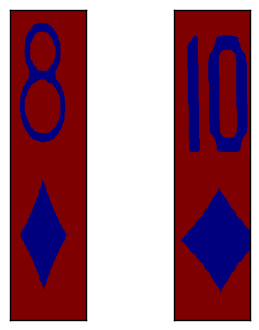

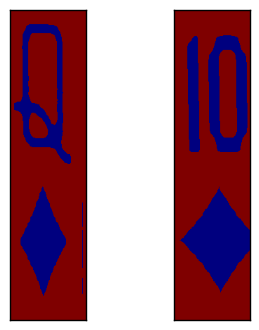

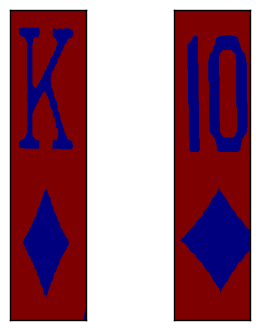

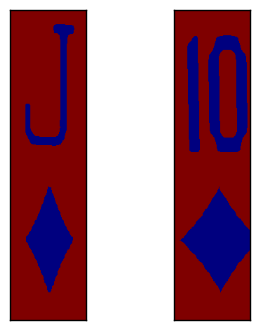

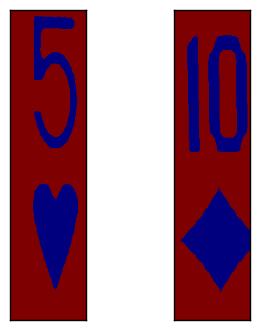

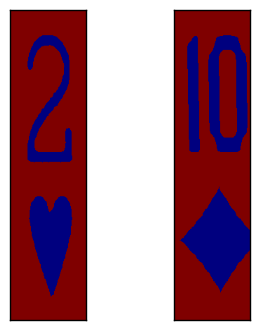

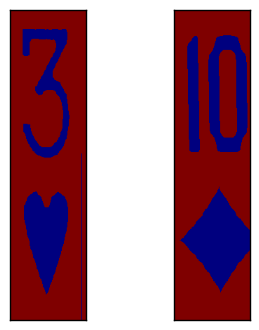

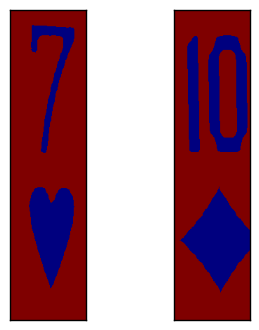

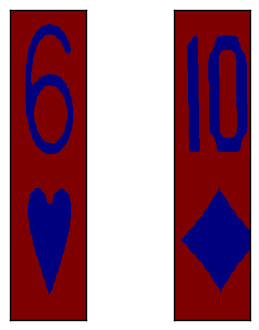

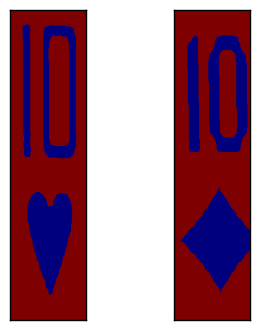

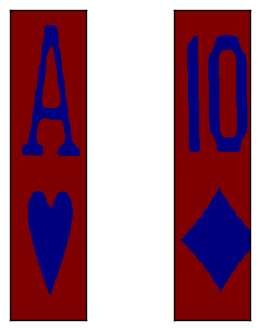

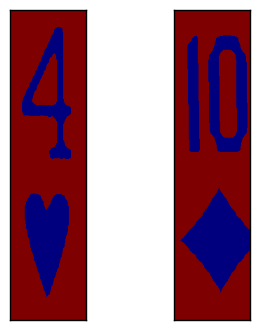

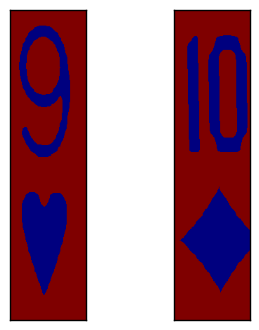

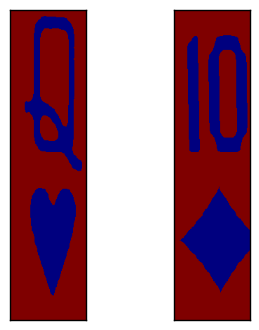

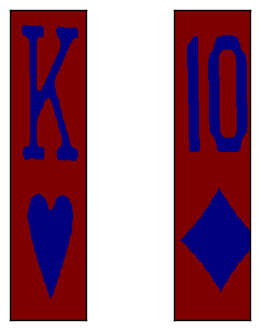

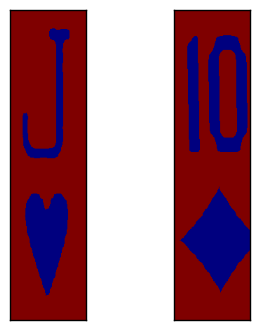

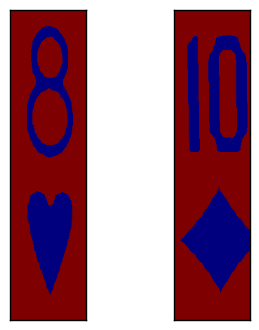

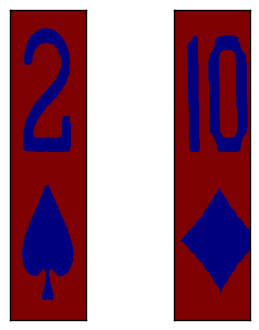

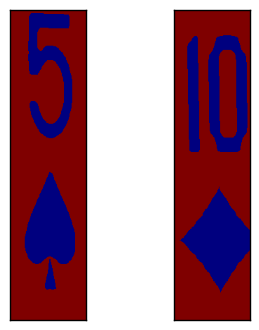

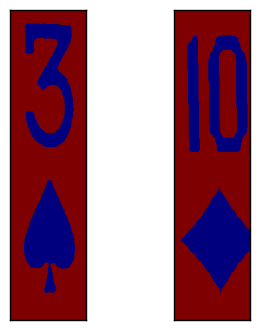

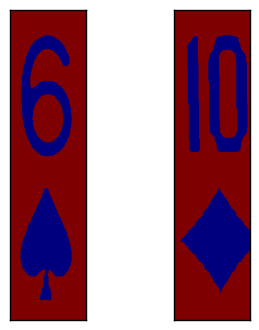

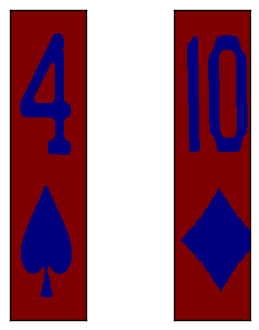

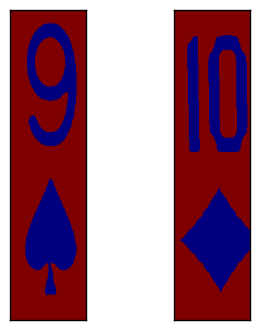

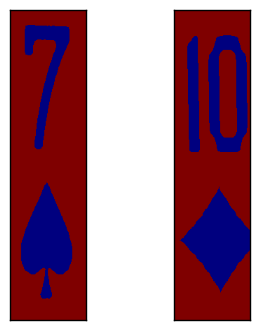

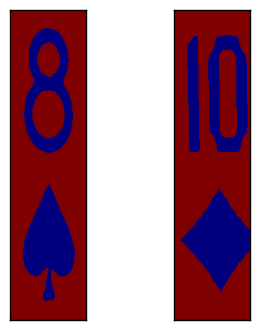

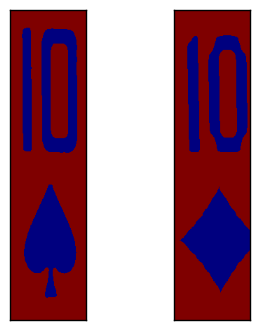

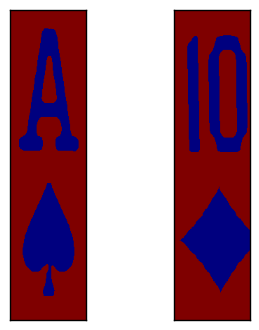

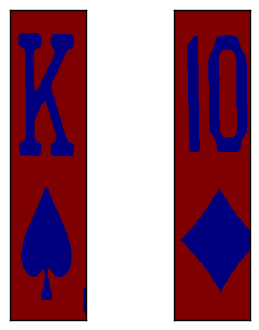

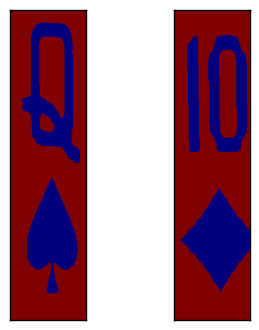

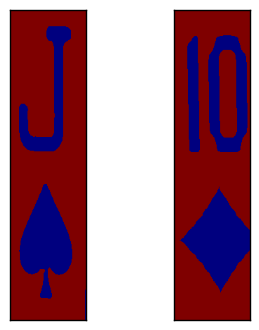

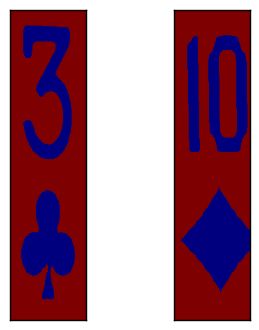

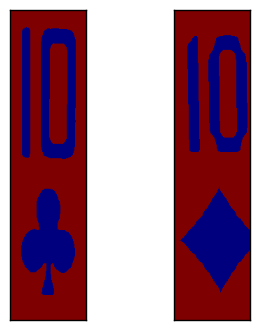

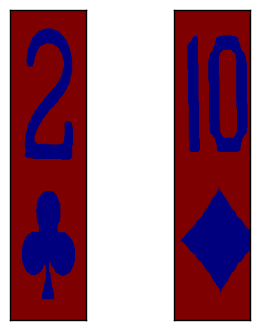

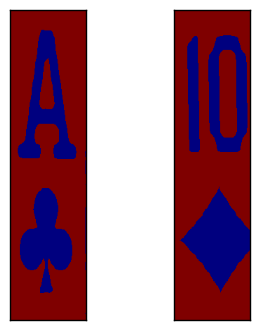

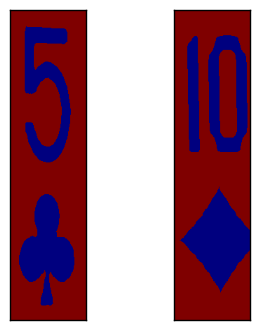

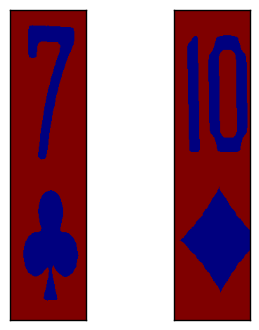

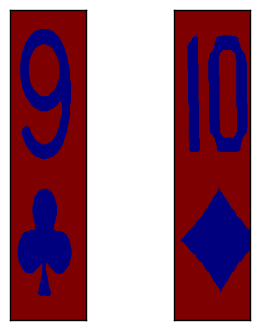

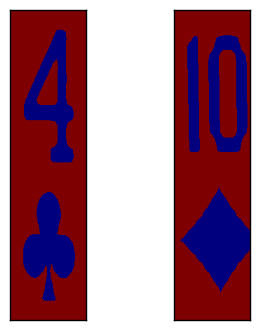

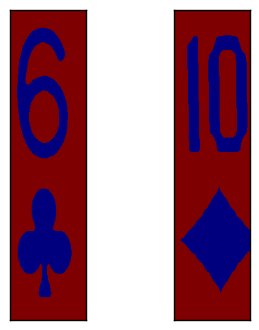

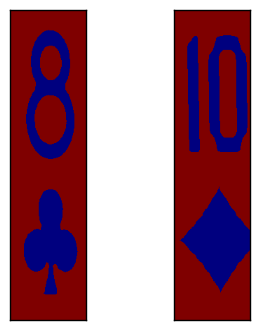

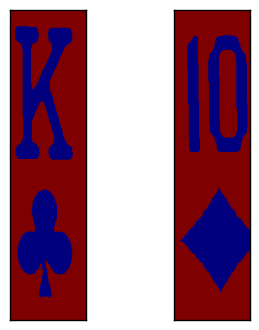

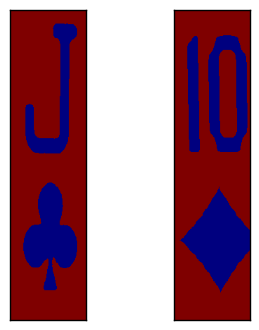

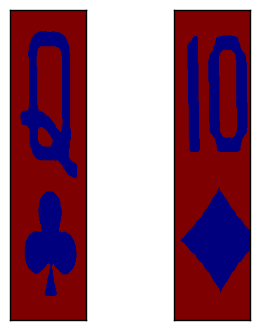

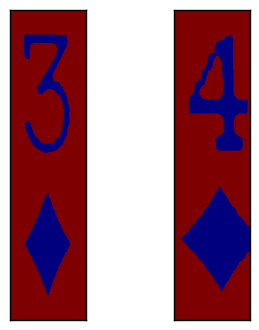

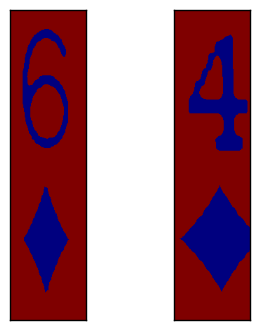

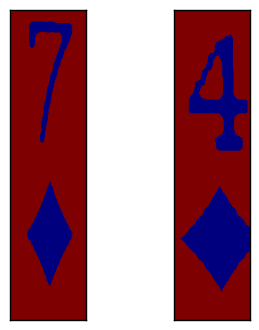

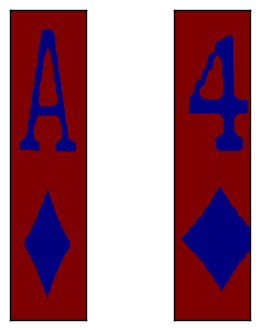

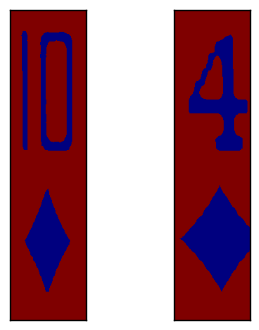

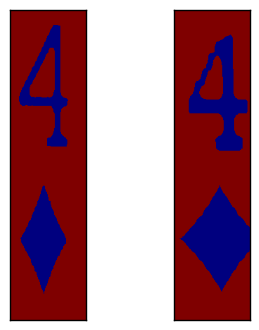

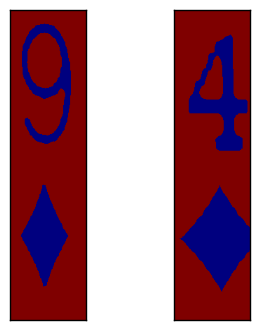

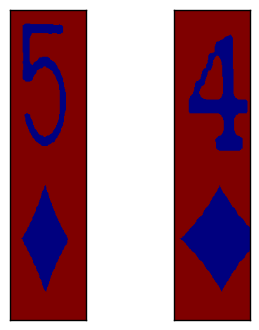

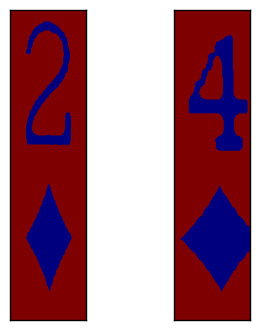

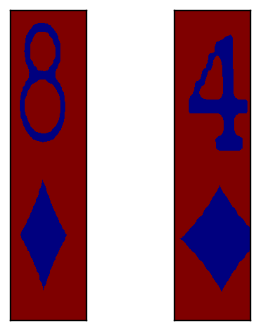

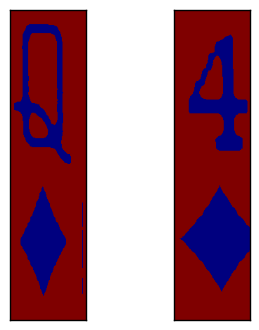

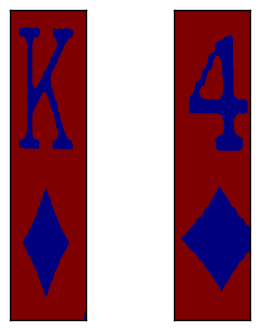

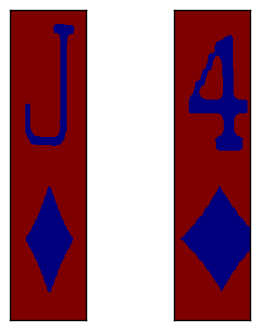

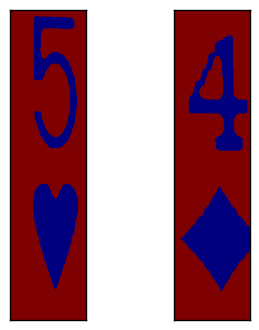

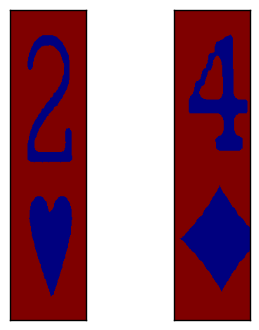

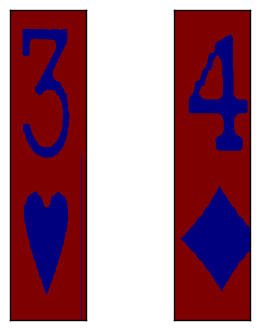

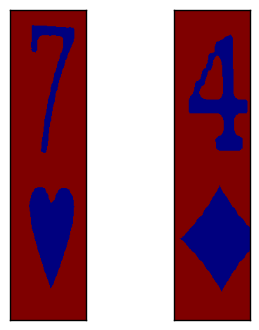

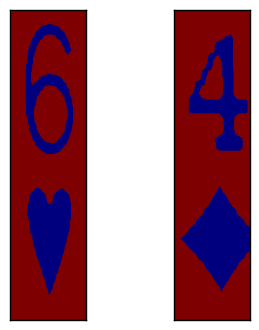

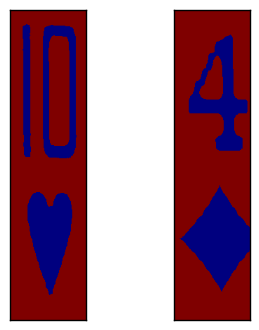

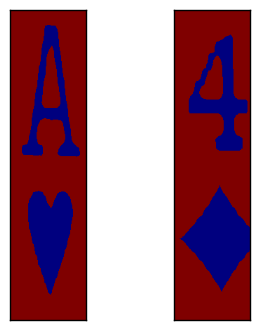

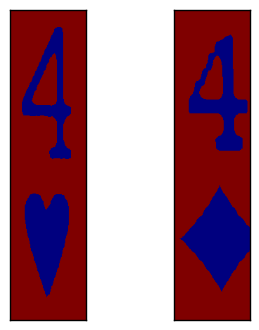

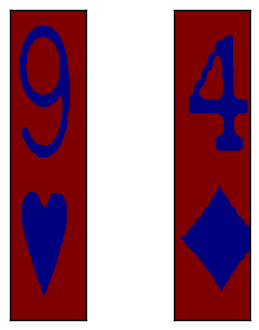

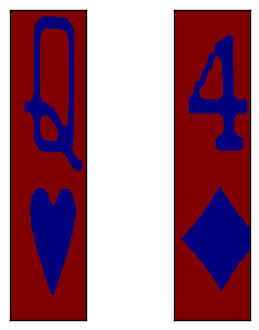

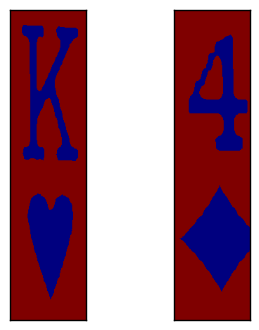

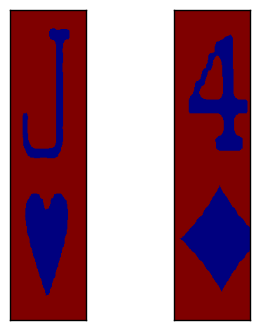

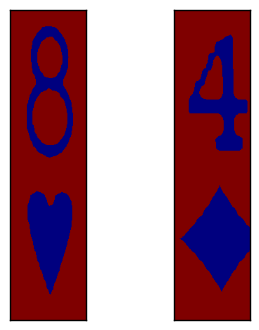

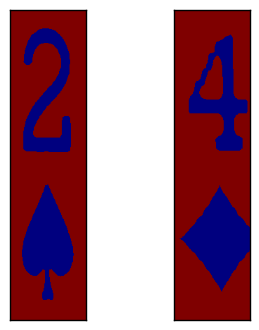

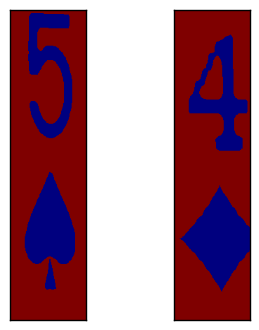

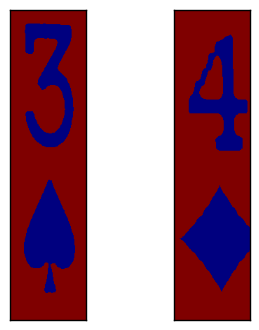

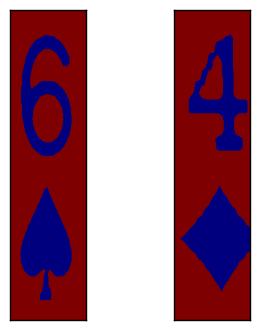

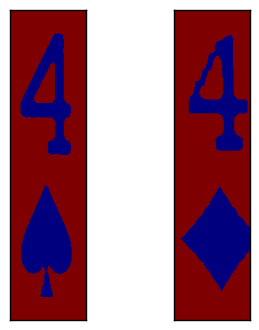

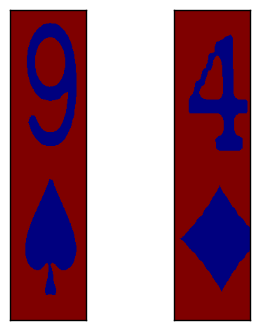

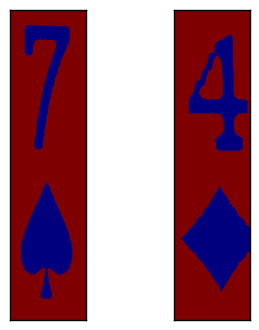

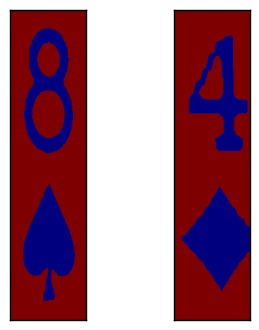

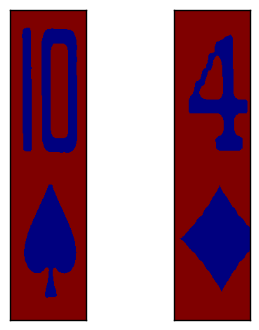

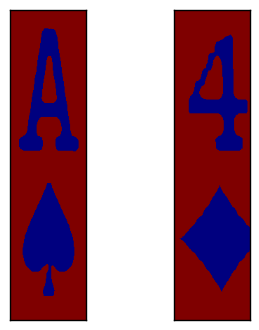

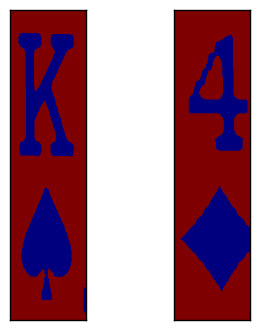

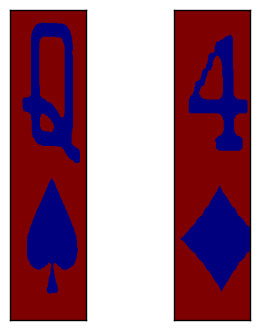

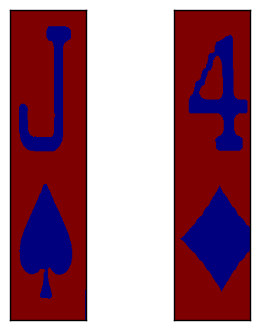

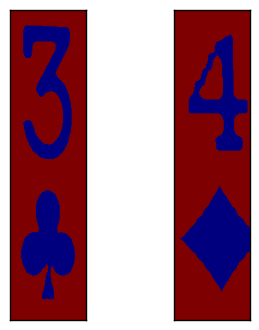

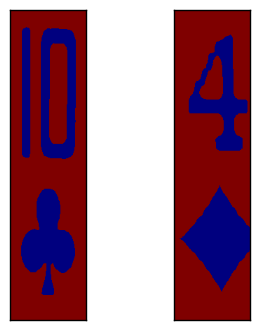

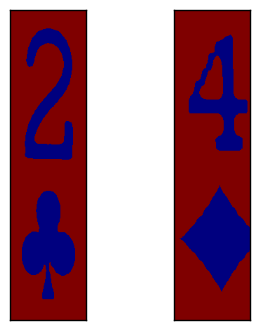

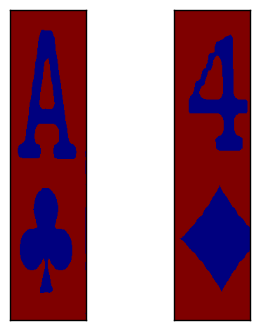

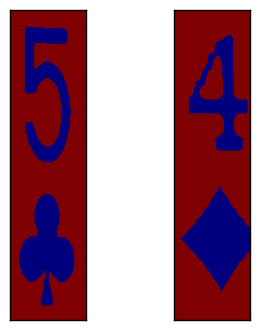

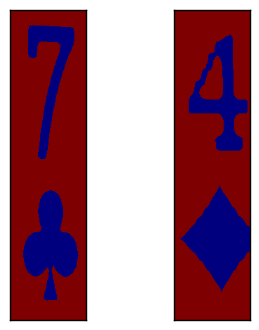

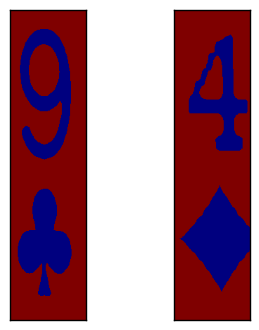

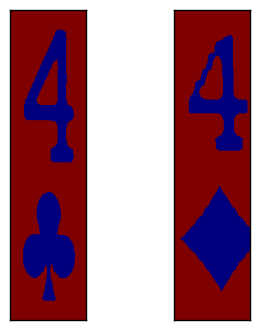

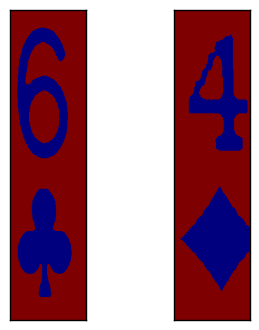

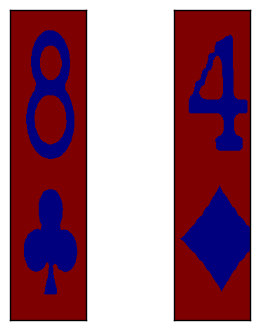

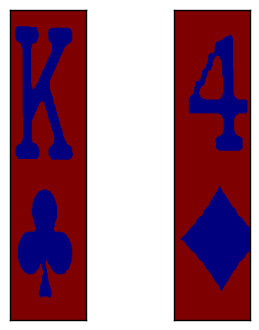

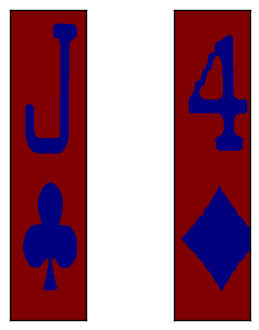

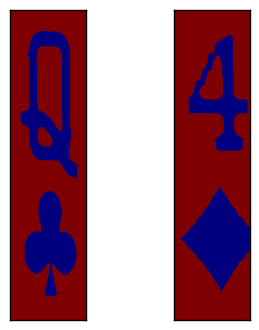

[('6', 'h'), ('K', 'h')]


In [301]:
filename = 'test/4dTd.png'
num_cards = 2
training_image_filename = ['train/train1.png', 'train/train2.png', 'train/train3.png', 'train/train4.png']
training_labels_filename = 'train/train.tsv'
num_training_cards = 52

training = get_training(training_labels_filename,training_image_filename,num_training_cards)

im = cv2.imread(filename)

cards = [find_closest_card(training,c) for c in getCards(im,num_cards)]
print cards
# getCards(cv2.imread(training_image_filename), num_training_cards)
# getCards2(im, num_cards)

In [86]:
def getCards2(im, numcards=13):
#     if numcards==2:
#         a = 150
#     else:
#         a = 120
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    flag, thresh = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY)
    image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea,reverse=True)[:numcards]
    
    for card in contours:
        peri = cv2.arcLength(card,True)
        approx = rectify(cv2.approxPolyDP(card,0.9*peri,True))

        h = np.array([ [0,0],[449,0],[449,449],[0,449] ],np.float32)

        transform = cv2.getPerspectiveTransform(approx,h) # how do these arguments work?
        warp = cv2.warpPerspective(im,transform,(450,450)) # how do these arguments work?

        fig, ax = plt.subplots(figsize=(2, 1))
        plt.imshow(warp,'gray')
        plt.title("")
        plt.xticks([]),plt.yticks([])
        plt.show()

In [299]:
def orb_match(im1, im2):
    orb = cv2.ORB_create(edgeThreshold=5, nlevels=4, nfeatures=100000)
    kp1, des1 = orb.detectAndCompute(im1, None)
    kp2, des2 = orb.detectAndCompute(im2, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
#     matches = sorted(matches, key = lambda x:x.distance)
    
    good = []
    for m in matches:
        if m.distance < 75:
            good.append([m])
    
    plt.subplot(131), plt.imshow(im1), plt.title('')
    plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(im2), plt.title('')
    plt.xticks([]), plt.yticks([])
    plt.show()
    
    return len(good)
#     print [x.distance for x in matches]
#     img3 = cv2.drawKeypoints(im2, kp2, None, color=(0,255,0), flags=0)
#     img3 = cv2.drawMatches(im1,kp1,im2,kp2,matches[-2:-1], None, flags=2)
#     print kp2
#     plt.imshow(img3),plt.show()



In [244]:
orb_match()

TypeError: orb_match() takes exactly 2 arguments (0 given)